# Práctica 2 - MLP para funciones lógicas - Lab 2
## Preparación de entorno
#### Instalar las librerías

In [282]:
# %pip install torch torchvision pandas matplotlib

#### Importar librerías de código

In [283]:
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split # type: ignore

### Preparación de los datos de entrenamiento


En primer lugar, importaremos nuestro dataset con pandas, con el fin de crear un dataframe que nos permita trabajar con los datos de forma más cómoda.

In [284]:
df_train = pd.read_csv("data/got_train.csv", usecols=['male', 'isMarried', 'isNoble', 'numDeadRelations', 'isPopular', 'book1','book2','book3','book4','book5', 'alive'])

Una vez tenemos el dataset con las columnas necesarias, dividiremos los datos entre las carácterísticas de entrenamiento y el atributo objetivo, que en este caso es *alive*.

In [285]:
# Características del entrenamiento
x_train = df_train[['male', 'isMarried', 'isNoble', 'numDeadRelations', 'isPopular', 'book1', 'book2', 'book3', 'book4', 'book5']]
# Objetivo
y_train = df_train['alive']

Antes de pasar con la definición del modelo, debemos convertir nuestros datos a tensores, de tal manera que podamos trabajar con ellos en PyTorch.  
En el caso del target, al ser un dataset unidimensional, debemos transformarlo a una matriz de una columna y n filas para que sea compatible con las funciones de pérdida y del modelo que usaremos posteriormente.

In [286]:
x_train_tensor = torch.tensor(x_train.values)
y_train_tensor = torch.tensor(y_train.values).view(-1, 1)

## MLP SetUp

Una vez hemos preparado nuestros datos de entrenamiento, procederemos con la definición de nuestro modelo. Para ello, empezaremos definiendo los hiperparámetros.

In [287]:
input_size = x_train_tensor.shape[1] # Número de características de entrada que va a usar el modelo.
hidden_size1 = 32 # Número de neuronas de la capa oculta
hidden_size2 = 64 # Número de neuronas de la capa oculta 2
output_size = 1 # Número de nueronas de salida. Ponemos 1 porque va a ser una clasificación binaria (vivo/muerto)

batch_size = 32
learning_rate = 0.01
num_epochs = 150
validation_split = 0.2 

Con los hiperparámetros definidos, podemos crear nuestro modelo MLP.

In [ ]:
class RedNeuronalGot(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(RedNeuronalGot, self).__init__()
        # Capas de la red
        self.capa1 = nn.Linear(input_size, hidden_size1)
        self.capa2 = nn.Linear(hidden_size1, hidden_size2)
        self.capa3 = nn.Linear(hidden_size2, hidden_size1)
        self.capa4 = nn.Linear(hidden_size1, output_size)

        #Función de activación
        self.relu = nn.ReLU()
        #Función de activación para la capa de salida (binaria)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.capa1(x))
        x = self.relu(self.capa2(x))
        x = self.capa4(x)
        x = self.sigmoid(x)  # Aplicamos Sigmoid para obtener un valor entre 0 y 1
        return x

En este caso, hemos decidido utilizar la función de activación Relu para las capas intermedias, y para la capa de salida, la sigmoidea, ya que nos va a sacar siempre un valor entre 0 y 1, que es lo que nos interesa a nosotros para nuestra predicción.  

A continuación, dividiremos los datos de entrenamiento y los de validación.

In [289]:
dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataset_size = len(x_train_tensor)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Ya con el dataset dividido y adaptado a a PyTorch, podemos proceder instanciando el modelo y definiendo su función de pérdida y optimizador. En este caso, al tratarse de un problema de predicción entre 0 y 1, la función de pérdida más adecuada es **Binary Cross-Entropy Loss**, ya que tiene una menor penalización para los errores más pequeños y tiene un enfoque más probabilístico, que es lo que estamos buscando. [Fuente](https://medium.com/@hatodi0945/a-comparison-between-mse-cross-entropy-and-hinge-loss-4d4fe63cca12#:~:text=The%20MSE%20loss%20is%20therefore,several%20iterations%20of%20model%20training.)

In [290]:
model = RedNeuronalGot(input_size=input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, output_size=output_size)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## MLP Entrenamiento básico

Con los últimos parámetros establecidos, podemos proceder con las funciones previas al entrenamiento. En primer lugar, definiremos la función de evaluación, que medirá el rendimiento de nuestro modelo durante el entrenamiento.

In [291]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            outputs = model(batch_x.float())
            loss = criterion(outputs, batch_y.float())
            total_loss += loss.item()

    return total_loss / len(dataloader)

Antes de empezar a entrenar el modelo, definiremos algunas variables que nos permitirán almacenar información importante relativa al entrenamiento.

In [292]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

Ya con todo listo, procederemos a entrenar nuestra red neuronal.

In [293]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        # Forward
        outputs = model(batch_x.float())
        loss = criterion(outputs, batch_y.float())
        # Back
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    val_loss = evaluate_model(model, val_loader, criterion)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs}]')
        print(f'Pérdida de entrenamiento: {avg_train_loss:.4f}')
        print(f'Pérdida de validación: {val_loss:.4f}')
        print('-' * 50)

model.load_state_dict(best_model_state)
print(f'\nMejor pérdida de validación: {best_val_loss:.4f}')

Época [10/150]
Pérdida de entrenamiento: 0.6549
Pérdida de validación: 0.6590
--------------------------------------------------
Época [20/150]
Pérdida de entrenamiento: 0.6483
Pérdida de validación: 0.6529
--------------------------------------------------
Época [30/150]
Pérdida de entrenamiento: 0.6413
Pérdida de validación: 0.6466
--------------------------------------------------
Época [40/150]
Pérdida de entrenamiento: 0.6319
Pérdida de validación: 0.6379
--------------------------------------------------
Época [50/150]
Pérdida de entrenamiento: 0.6177
Pérdida de validación: 0.6271
--------------------------------------------------
Época [60/150]
Pérdida de entrenamiento: 0.6007
Pérdida de validación: 0.6151
--------------------------------------------------
Época [70/150]
Pérdida de entrenamiento: 0.5850
Pérdida de validación: 0.6052
--------------------------------------------------
Época [80/150]
Pérdida de entrenamiento: 0.5775
Pérdida de validación: 0.6010
-------------------

Una vez hemos entrenado la red, podemos realizar una gráfica nos muestre como ha ido evolucionando la pérdida a lo largo del entrenamiento. Esto nos permitirá determinar si nuestra red ha aprendido correctamente, observar si necesita más epochs o si necesitamos cambiar algún hiperparámetro.

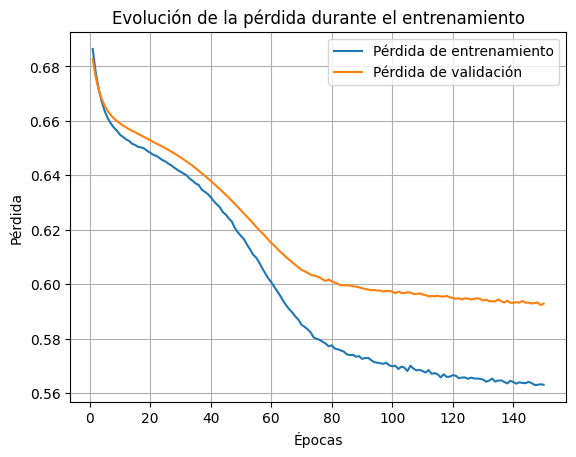

In [294]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(range(1, num_epochs + 1), train_losses, label='Pérdida de entrenamiento')
plt.plot(range(1, num_epochs + 1), val_losses, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

## MLP Evaluación final